<a href="https://colab.research.google.com/github/camulro/Aprendizaje-I-new/blob/main/EJERCICIO_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**El objetivo del ejercicio es:**

- Optimizar arquitectura de la red

- Partir training en training + validación usando como ejemplo lo que se hacía en el notebook de las caras (carpeta 03-caras)

- Sacar heatmaps

In [1]:
COLAB = True

In [2]:
if COLAB:
    #%tensorflow_version 1.x
    !pip install h5py==2.10.0

     |████████████████████████████████| 2.9 MB 5.6 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


Si se desea ejecutar en local:

- Descargar el dataset de training de: https://drive.google.com/file/d/1ChJn1h340ECm1uezE-oLr6TwCbeGglvQ

- Y el de test de: https://drive.google.com/file/d/1STokCqelhLeiwlTa2YX-TM9SNCx74-an

- Poner variable COLAB a False

In [3]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.regularizers import l1, l2
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

In [4]:
!ls -la

total 16
drwxr-xr-x 1 root root 4096 Dec  3 14:33 .
drwxr-xr-x 1 root root 4096 Dec 31 04:11 ..
drwxr-xr-x 4 root root 4096 Dec  3 14:33 .config
drwxr-xr-x 1 root root 4096 Dec  3 14:33 sample_data


In [5]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1ChJn1h340ECm1uezE-oLr6TwCbeGglvQ',
                                        dest_path='./seg_train.zip', unzip=True)
    gdd.download_file_from_google_drive(file_id='1STokCqelhLeiwlTa2YX-TM9SNCx74-an',
                                        dest_path='./seg_test.zip', unzip=True)
    #descarga y descomprime train y test

Unzipping...Done.
Unzipping...Done.


Primero trataremos test como si fura validación.
Luego partiremos training en train y validación como en el ejercicio de caras

In [6]:
!ls -la

total 253668
drwxr-xr-x 1 root root      4096 Dec 31 04:12 .
drwxr-xr-x 1 root root      4096 Dec 31 04:11 ..
drwxr-xr-x 4 root root      4096 Dec  3 14:33 .config
drwxr-xr-x 4 root root      4096 Dec 31 04:12 __MACOSX
drwxr-xr-x 1 root root      4096 Dec  3 14:33 sample_data
drwxr-xr-x 8 root root      4096 Dec 31 04:12 seg_test
-rw-r--r-- 1 root root  45638665 Dec 31 04:12 seg_test.zip
drwxr-xr-x 8 root root      4096 Dec 31 04:12 seg_train
-rw-r--r-- 1 root root 214084517 Dec 31 04:12 seg_train.zip


In [7]:
!ls seg_train

buildings  forest  glacier  mountain  sea  street


In [8]:
!ls seg_test

buildings  forest  glacier  mountain  sea  street


In [9]:
!ls seg_train/buildings

0.jpg	   12578.jpg  14916.jpg  17468.jpg  20017.jpg  4600.jpg  7382.jpg
10006.jpg  12590.jpg  14918.jpg  17479.jpg  20027.jpg  4620.jpg  7383.jpg
10014.jpg  125.jpg    14947.jpg  17480.jpg  2002.jpg   4621.jpg  739.jpg
10018.jpg  12602.jpg  14952.jpg  17491.jpg  20048.jpg  4623.jpg  7418.jpg
1001.jpg   12615.jpg  14958.jpg  17495.jpg  20054.jpg  4630.jpg  742.jpg
10029.jpg  12617.jpg  14968.jpg  17503.jpg  2038.jpg   4631.jpg  7439.jpg
10032.jpg  12629.jpg  14984.jpg  17516.jpg  2041.jpg   4634.jpg  7443.jpg
10056.jpg  12632.jpg  14991.jpg  1751.jpg   2043.jpg   463.jpg	 7455.jpg
1009.jpg   12636.jpg  1501.jpg	 17520.jpg  2059.jpg   4667.jpg  7463.jpg
10113.jpg  1263.jpg   15026.jpg  17537.jpg  2069.jpg   4686.jpg  7471.jpg
10126.jpg  12649.jpg  15030.jpg  17539.jpg  2076.jpg   4715.jpg  7478.jpg
1012.jpg   12659.jpg  1503.jpg	 1753.jpg   2083.jpg   4748.jpg  747.jpg
10144.jpg  12668.jpg  15042.jpg  17541.jpg  2088.jpg   4770.jpg  7491.jpg
10151.jpg  12669.jpg  15045.jpg  17545.jpg  20

In [10]:
ficheros = glob("./seg_train/forest/*")
ficheros[0]

'./seg_train/forest/16953.jpg'

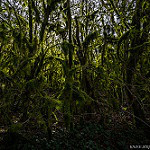

In [11]:
imagen = load_img(ficheros[3])
imagen

In [12]:
imagen.size

(150, 150)

In [13]:
# parto training en training + validación:

clases = ["buildings", "forest", "glacier", "mountain", "sea", "street"]

rutas_trval  = []
clases_trval = []
for clase in clases:#para cada clase saca la ruta de todos los elementos de training
    rutas_aux  = glob("./seg_train/{}/*".format(clase))
    clases_aux = len(rutas_aux)*[clase] #tienes tantos elementos de una clase como rutas tienes
    print(rutas_aux[:3])
    print(clases_aux[:3])

    rutas_trval.extend(rutas_aux)
    clases_trval.extend(clases_aux)


['./seg_train/buildings/191.jpg', './seg_train/buildings/13364.jpg', './seg_train/buildings/6747.jpg']
['buildings', 'buildings', 'buildings']
['./seg_train/forest/16953.jpg', './seg_train/forest/8688.jpg', './seg_train/forest/5219.jpg']
['forest', 'forest', 'forest']
['./seg_train/glacier/6110.jpg', './seg_train/glacier/19443.jpg', './seg_train/glacier/697.jpg']
['glacier', 'glacier', 'glacier']
['./seg_train/mountain/5334.jpg', './seg_train/mountain/18884.jpg', './seg_train/mountain/1582.jpg']
['mountain', 'mountain', 'mountain']
['./seg_train/sea/17077.jpg', './seg_train/sea/7259.jpg', './seg_train/sea/19133.jpg']
['sea', 'sea', 'sea']
['./seg_train/street/5095.jpg', './seg_train/street/18517.jpg', './seg_train/street/12622.jpg']
['street', 'street', 'street']


In [14]:
import pandas as pd

df_trval = pd.DataFrame({"ruta":rutas_trval, "clase":clases_trval})#el dataframe tiene dos columnas, una con las rutas y otra con las clases
df_trval

,ruta,clase
0,./seg_train/buildings/191.jpg,buildings
1,./seg_train/buildings/13364.jpg,buildings
2,./seg_train/buildings/6747.jpg,buildings
3,./seg_train/buildings/5743.jpg,buildings
4,./seg_train/buildings/4806.jpg,buildings
...,...,...
14029,./seg_train/street/11459.jpg,street
14030,./seg_train/street/15930.jpg,street
14031,./seg_train/street/1856.jpg,street
14032,./seg_train/street/147.jpg,street


In [15]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_trval, train_size=0.5, random_state=1, stratify=df_trval["clase"])
#con stratify las frecuencias de las clases son las mismas en train y en vlidación para evitar que una clase esté menos representada

In [16]:
df_train["clase"].value_counts() / len(df_train) * 100

mountain     17.899387
glacier      17.129828
street       16.973065
sea          16.203506
forest       16.175004
buildings    15.619210
Name: clase, dtype: float64

In [17]:
df_val["clase"].value_counts() / len(df_train) * 100

mountain     17.899387
glacier      17.129828
street       16.973065
sea          16.203506
forest       16.189255
buildings    15.604959
Name: clase, dtype: float64

In [18]:
##train_data_dir = 'seg_train'
##validation_data_dir = 'seg_test'
test_data_dir = 'seg_test'

batch_size = 64#cada lote de 64 imágenes va a pasar por la red y se va a actualizar, a mayor num la época se actualiza menos veces pero de una manera más robusta
#si es un lote pequeño de imágenes raras la red se actualiza sobre esas

Para ver opciones:

https://keras.io/api/preprocessing/image/#imagedatagenerator-class


In [19]:

# data augmentation:

train_datagen = ImageDataGenerator(
    rescale=1. / 255, #divide entre 255 cada píxel para tener los datos entre 0 y 1
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='mirror', # 'nearest',
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

In [20]:
imagen_num = np.array([img_to_array(imagen)])

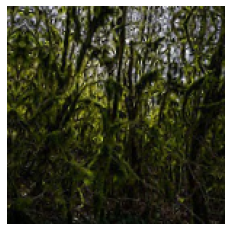

In [21]:
plt.imshow(train_datagen.flow(imagen_num)[0][0])
plt.axis("off");

In [22]:
# dimensiones a las que vamos a llevar las imágenes
img_width, img_height = 150, 150 #se puede poner más pequeño para que la red tenga menos parámetros y sea menos complejo
#también entrenaría más rápido pero cuanto menor, menos información tenemos

normed_dims = (img_height, img_width)

In [23]:
normed_dims

(150, 150)

In [26]:
# sparse_categorical_crossentropy

#building: 0
# 1,0,0,0,0,0

# forest': 1
# 0,1,0,0,0,0

# glacier: 2
# 0,0,1,0,0,0

# mountain: 3
# 0,0,0,1,0,0

# sea: 4,
# 0,0,0,0,1,0

# street: 5
# 0,0,0,0,0,1

# se ordenan alfabéticamente y se asignan esos códigos

In [25]:
# Definir arquitectura del modelo:

rate = 0.
input_shape = normed_dims + (3,)

#optimizer = "sgd"  # más fino, más lento
#optimizer = "adam" # muy rápido, eso lo hace a veces inestable
optimizer = "rmsprop" # bueno en general

model = Sequential()

#model.add(BatchNormalization(input_shape=input_shape))
model.add(Dropout(rate=rate, input_shape=input_shape))
model.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu'))
model.add(MaxPooling2D())
#model.add(Dropout(rate=rate))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPooling2D())
#model.add(Dropout(rate=rate))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D())
#model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dropout(rate=rate))
model.add(Dense(5, activation='relu', kernel_regularizer=l2(0.1)))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 146, 146, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        2

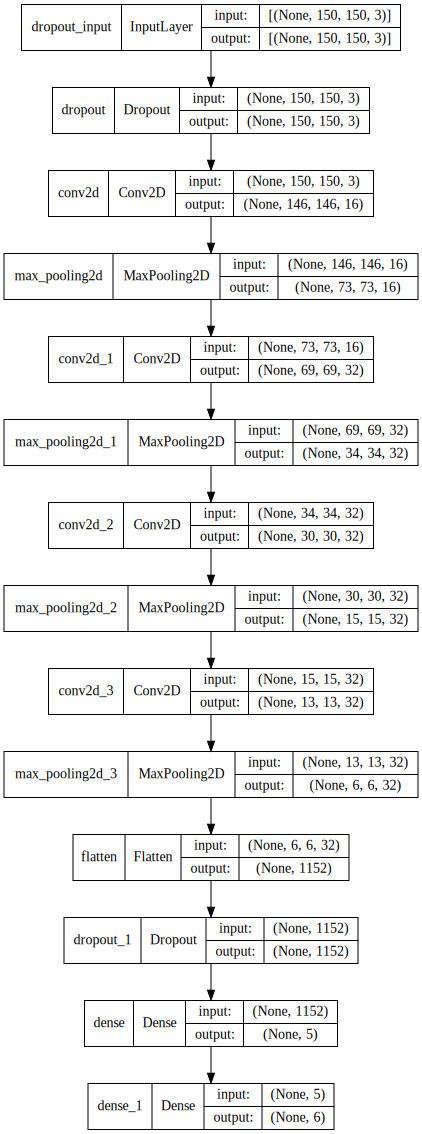

In [28]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [29]:
def preprocess_input(x):
    return x/255

In [30]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    #rotation_range=40,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #fill_mode='nearest',
    #shear_range=0.2,
    #zoom_range=0.2,
    horizontal_flip=True
    )

val_datagen  = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

In [31]:
batch_size

64

In [32]:
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col = "ruta",
    y_col = "clase",
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse')

validation_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col = "ruta",
    y_col = "clase",
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

Found 7017 validated image filenames belonging to 6 classes.
Found 7017 validated image filenames belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [33]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [34]:
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n
number_test_samples  = test_generator.n

number_train_samples, number_val_samples, number_test_samples

(7017, 7017, 3000)

In [35]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [36]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

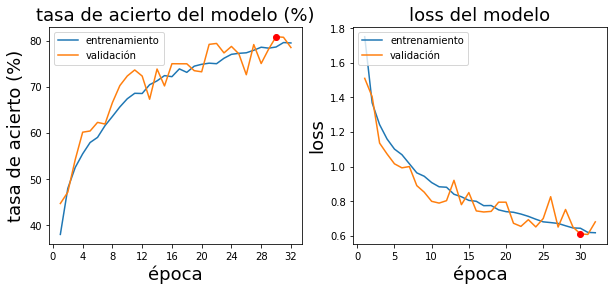

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


 58/109 [==============>...............] - ETA: 5s - loss: 0.5907 - accuracy: 0.8121

KeyboardInterrupt: ignored

In [37]:
epochs = 50

modelpath="best_model.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                              save_best_only=True,
                              mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    history = model.fit_generator(generator = train_generator, 
                                  steps_per_epoch=number_train_samples // batch_size,
                                  epochs=1,
                                  callbacks=callbacks_list,
                                  verbose=1,
                                  shuffle = True,
                                  validation_data=validation_generator,
                                  validation_steps=number_val_samples // batch_size
                                  )
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [38]:
!ls -la

total 254156
drwxr-xr-x 1 root root      4096 Dec 31 04:51 .
drwxr-xr-x 1 root root      4096 Dec 31 04:11 ..
-rw-r--r-- 1 root root    498824 Dec 31 05:05 best_model.h5
drwxr-xr-x 4 root root      4096 Dec  3 14:33 .config
drwxr-xr-x 4 root root      4096 Dec 31 04:12 __MACOSX
drwxr-xr-x 1 root root      4096 Dec  3 14:33 sample_data
drwxr-xr-x 8 root root      4096 Dec 31 04:12 seg_test
-rw-r--r-- 1 root root  45638665 Dec 31 04:12 seg_test.zip
drwxr-xr-x 8 root root      4096 Dec 31 04:12 seg_train
-rw-r--r-- 1 root root 214084517 Dec 31 04:12 seg_train.zip


In [39]:
model = load_model(modelpath)

## **Resultados obtenidos**

In [40]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model.evaluate(test_generator)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

110/110 [==============================] - 10s 93ms/step - loss: 0.5537 - accuracy: 0.8247
Train loss    : 0.5537228584289551
Train accuracy: 0.8247114419937134

110/110 [==============================] - 11s 99ms/step - loss: 0.6146 - accuracy: 0.8073
Val loss    : 0.6146487593650818
Val accuracy: 0.8073250651359558

47/47 [==============================] - 7s 146ms/step - loss: 0.6111 - accuracy: 0.8067
Test loss     : 0.6111472845077515
Test accuracy : 0.8066666722297668


In [41]:
y_real = test_generator.classes
y_pred_proba = model.predict_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [42]:
y_real[:5]

array([0, 0, 0, 0, 0], dtype=int32)

In [43]:
y_pred_proba[:5]

array([[9.61336195e-01, 1.96607856e-04, 2.07614721e-04, 3.56671488e-04,
        2.90321074e-02, 8.87076929e-03],
       [6.19132578e-01, 2.35900301e-02, 2.67759751e-04, 1.06445479e-03,
        1.61871500e-03, 3.54326457e-01],
       [2.39292562e-01, 1.05933104e-04, 3.09471761e-05, 6.88384389e-05,
        4.14203946e-03, 7.56359756e-01],
       [9.19862688e-01, 1.79589071e-04, 2.17326611e-04, 3.16268386e-04,
        4.24156971e-02, 3.70083861e-02],
       [6.43998682e-02, 3.55952303e-04, 1.23222619e-01, 2.08687671e-02,
        7.23663211e-01, 6.74895942e-02]], dtype=float32)

In [44]:
test_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [45]:
num2class = {test_generator.class_indices[x]:x  for x in test_generator.class_indices.keys()}
num2class

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

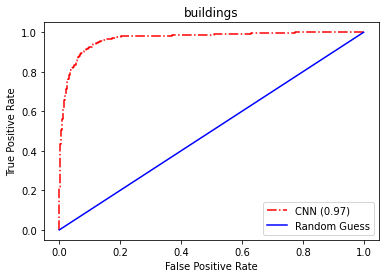

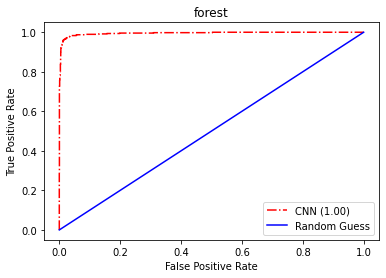

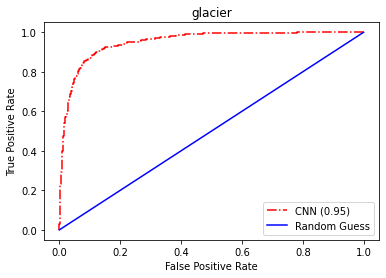

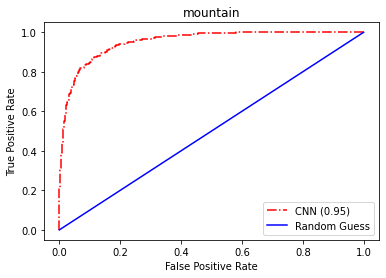

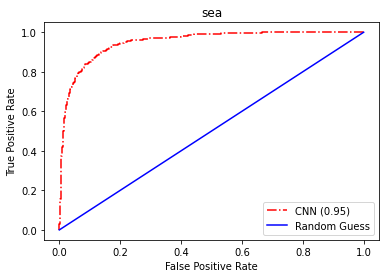

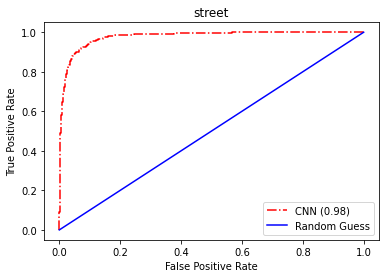

In [46]:
for clase in range(6):
    nombre_clase = num2class[clase]

    fpr, tpr, thresholds = roc_curve(y_real==clase, y_pred_proba[:,clase])
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
    ax1.set_title(nombre_clase)
    ax1.legend()
    plt.show()#la clase que menos le cuesta separar a la red es forest porque tiene la mejor curva roc

## **Visualización de ejemplos de test**

In [47]:
test_datagen2 = ImageDataGenerator(dtype='float32')

test_generator2 = test_datagen2.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=test_generator.n,
    shuffle=False,
    class_mode='sparse')

Found 3000 images belonging to 6 classes.


In [48]:
test_generator2.reset()
X_te, y_te = test_generator2.next()

In [49]:
test_generator2.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [50]:
y_te

array([0., 0., 0., ..., 5., 5., 5.], dtype=float32)

In [51]:
def show_probs(probs):
    cadena = ""
    for i in range(len(num2class)):
        cadena = cadena + "{}: {}% ".format(num2class[i], int(100*probs[i]))
    print(cadena)

Clase real: glacier
buildings: 0% forest: 0% glacier: 23% mountain: 39% sea: 36% street: 0% 


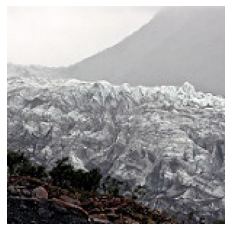

In [52]:
ind_te1 = 1020 # 145

image = X_te[ind_te1].copy()

print("Clase real:", num2class[y_te[ind_te1]])
plt.imshow(image/255, cmap='jet')
plt.axis("off")
p = model.predict(preprocess_input(np.array([image])))[0]

show_probs(p)

In [53]:
!ls

best_model.h5  sample_data  seg_test.zip  seg_train.zip
__MACOSX       seg_test     seg_train


In [54]:
# Para descargar el modelo a local:

#from google.colab import files
#files.download('./best_model.h5')

### Heatmaps

In [55]:
test_data_dir

'seg_test'

In [56]:
# primero cargo a memoria los ejemplos de test:

test_datagen2 = ImageDataGenerator(dtype='float32',
                                   preprocessing_function = preprocess_input)

test_generator2 = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=test_generator.n, # todas las imágenes del directorio test
    shuffle=False,
    class_mode='sparse') # binary: 0/1. Sparse: entero a partir de 0. Categorical: one hot

Found 3000 images belonging to 6 classes.


In [57]:
test_generator2.reset()
X_te, y_te = test_generator2.next()#carga todos los datos de test a memoria

In [58]:
X_te.shape

(3000, 150, 150, 3)

In [59]:
#ha copiado de caras:
import tensorflow as tf
import cv2

def find_ind_last_conv2D(model):
    ind_last_conv2D_layer = None
    for i,x in enumerate(model.layers):
        if x.__class__.__name__ == "Conv2D":
            ind_last_conv2D_layer = i
    return ind_last_conv2D_layer #identifica cual es la ultima capa convolutiva


def show_heatmap(model, im):
    imag = np.expand_dims(im, axis=0) # de 1 imagen pasamos a 1 conjunto de 1 imagen
    probs = model.predict(imag)[0]
        
    # The is the output feature map of the last convolutional layer
    last_conv_layer = model.layers[find_ind_last_conv2D(model)]
    
    # This is the gradient of the "benign" class with regard to
    # the output feature map of last convolutional layer
    with tf.GradientTape() as tape:
        aux = model.output
        #aux = model.layers[-2].output # salida de la última capa densa antes de softmax

        iterate = tf.keras.models.Model([model.inputs], [aux, last_conv_layer.output])
        model_out, last_conv_layer = iterate(imag)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)

        # mean intensity of the gradient over a specific feature map channel:
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)    
    heatmap = np.maximum(heatmap, 0) # se quitan los negativos (se ponen a 0)
    heatmap /= np.max(heatmap) # se normaliza entre 0 y 1
    heatmap = heatmap[0] # pasamos de 1 conjunto de 1 heatmap a 1 heatmap
    
    # We use cv2 to load the original image
    #img = cv2.imread(img_path)
    img = imag[0]
    
    img = np.zeros((im.shape[0],im.shape[1],3))
#    print(im.shape, imag.shape)
    for i in range(3):
        img[:,:,i] = imag[0,:,:,0]

    
    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    
    # We apply the heatmap to the original image
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) / 255
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_BONE) / 255
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT) / 255
    
    
    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.5 + 0.5*im
    #print(heatmap.min(), heatmap.max(), heatmap.mean(), heatmap.std())
    #print(img.min(), img.max(), img.mean(), img.std())
    #print(superimposed_img.min(),  superimposed_img.max(),
    #      superimposed_img.mean(), superimposed_img.std())
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(im, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,2)
    plt.imshow(heatmap, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,3)
    plt.imshow(superimposed_img, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.show()
    show_probs(probs)
    #print(np.shape(imag))
    ##prob = 100*model.predict(imag)[0][class_indices["female"]]
    ##print("Probabilidad clase female: {:2.1f}%".format(prob))
    ##prob = 100*model.predict(imag)[0][class_indices["male"]]
    ##print("Probabilidad clase male  : {:2.1f}%".format(prob))
    ##print("\n\n")
    return heatmap, superimposed_img

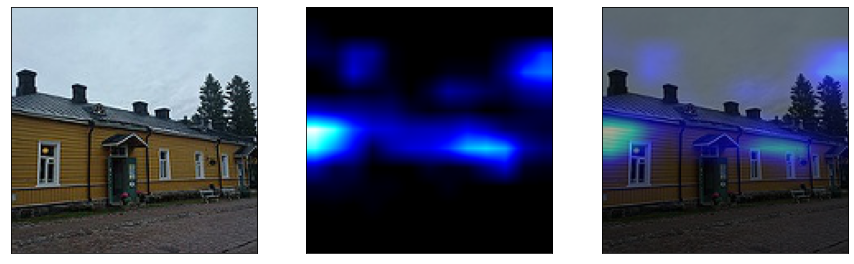

buildings: 76% forest: 0% glacier: 0% mountain: 0% sea: 0% street: 21% 
Real class: buildings





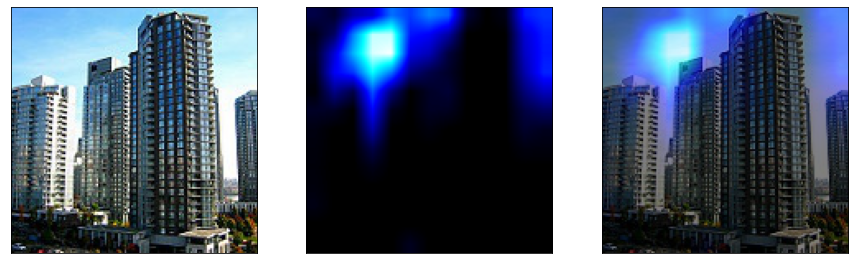

buildings: 94% forest: 4% glacier: 0% mountain: 0% sea: 0% street: 0% 
Real class: buildings





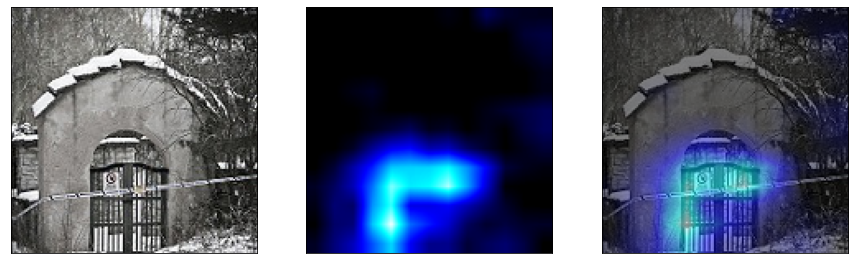

buildings: 83% forest: 0% glacier: 0% mountain: 0% sea: 14% street: 2% 
Real class: buildings





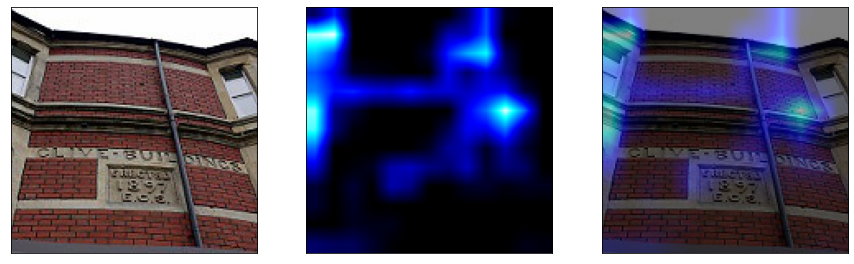

buildings: 67% forest: 0% glacier: 0% mountain: 0% sea: 24% street: 8% 
Real class: buildings





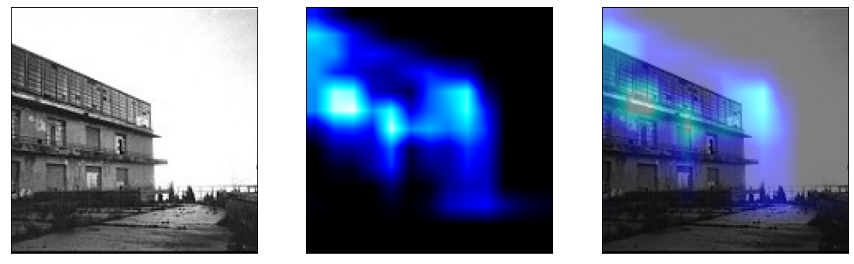

buildings: 40% forest: 1% glacier: 12% mountain: 2% sea: 30% street: 12% 
Real class: buildings





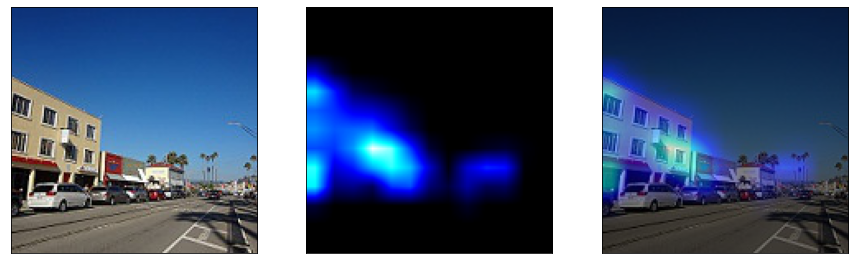

buildings: 59% forest: 0% glacier: 0% mountain: 0% sea: 26% street: 13% 
Real class: buildings





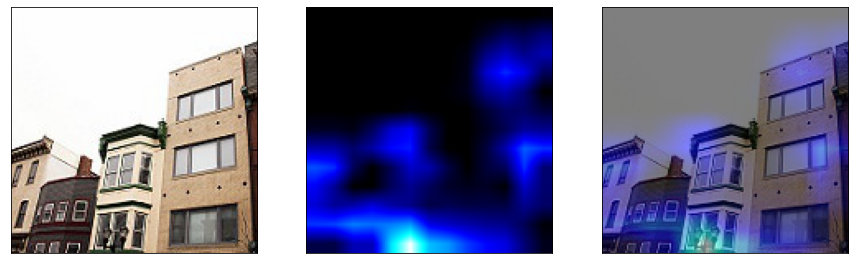

buildings: 98% forest: 0% glacier: 0% mountain: 0% sea: 1% street: 0% 
Real class: buildings





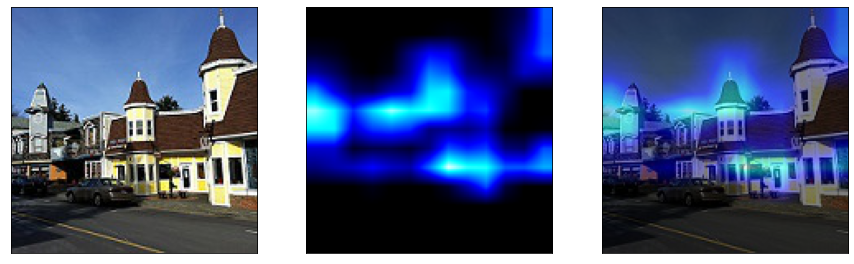

buildings: 85% forest: 0% glacier: 0% mountain: 0% sea: 0% street: 14% 
Real class: buildings





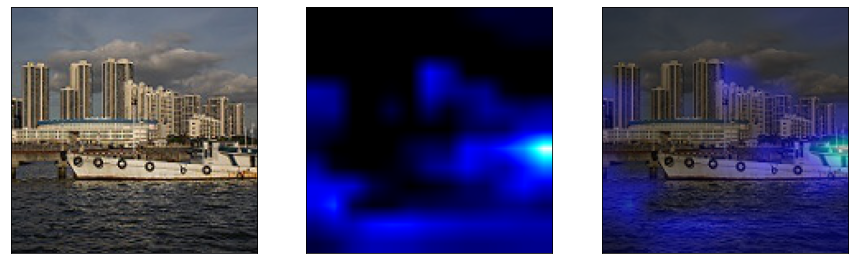

buildings: 30% forest: 0% glacier: 0% mountain: 0% sea: 0% street: 69% 
Real class: buildings





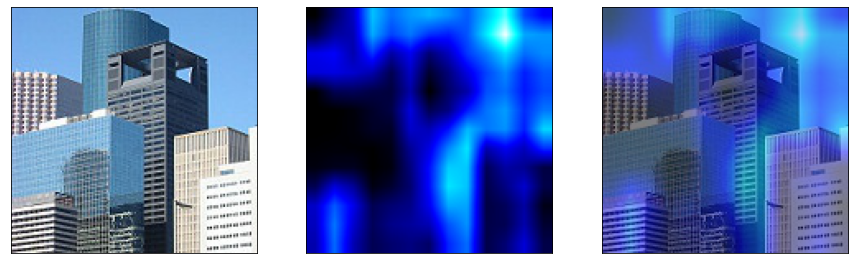

buildings: 99% forest: 0% glacier: 0% mountain: 0% sea: 0% street: 0% 
Real class: buildings





In [60]:
ind = 1041 # visualizamos 10 ejemplos de test a partir de este (en test hay 2002 ejemplos)
ind = 200

for i in range(ind, ind+10):
    show_heatmap(model, X_te[i])
    print("Real class:", num2class[y_te[i]])
    print("\n\n")

In [ ]:
num2class

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

### Mayores equivocaciones en una clase

In [ ]:
y_pred_proba = model.predict(X_te)

In [ ]:
clase = 0

inds = np.where(y_te == clase)[0]

inds_mayores_errores = sorted(inds, key=lambda ind:y_pred_proba[ind, clase])
n_errores = 10

for ind in inds_mayores_errores[:n_errores]:
    show_heatmap(model, X_te[ind])
    print("Real class:", num2class[y_te[ind]])
    print("\n\n")